In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [17]:
def load_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    data = pd.DataFrame(data)
    stim = np.array(data['stim']).reshape(-1, 1)
    rho = np.array(data['rho']).reshape(-1, 1)
    return data, stim, rho


In [18]:
data, stim, rho = load_data('./c1p8.pickle')
print(len(data))
print(f'stimulus (shape): {stim.shape}')
print(f'spikes (shape): {rho.shape}')

600000
stimulus (shape): (600000, 1)
spikes (shape): (600000, 1)


Estimating `Spike-Triggered Average`

In [19]:
num_timesteps = 300
sampling_period = 2

In [20]:
def compute_sta(stim, rho):
    sta = np.zeros((num_timesteps, 1))
    spike_times = np.where(rho == 1)[0]
    spike_times = spike_times[spike_times >= num_timesteps]
    num_spikes = len(spike_times)
    print(f'Number of spikes considered for STA: {num_spikes}')

    for t in spike_times:
        sta += stim[t - num_timesteps: t]

    sta /= num_spikes

    return sta

Number of spikes considered for STA: 53553


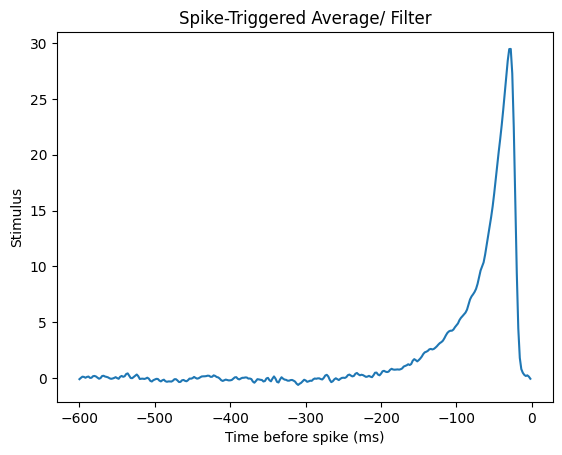

In [21]:
sta = compute_sta(stim, rho)
plt.plot(np.arange(-num_timesteps * sampling_period, 0, sampling_period).reshape(-1, 1), sta)
plt.xlabel('Time before spike (ms)')
plt.ylabel('Stimulus')
plt.title('Spike-Triggered Average/ Filter')
plt.show()

Calculating `Response` using `Spike-Triggered Average`

In [22]:
def response(stim, sta):
    T = len(sta)
    g = np.zeros((len(stim), 1))

    for t in range(T, len(stim)):
        g[t] = np.dot(sta.T, stim[t - T: t])

    return g

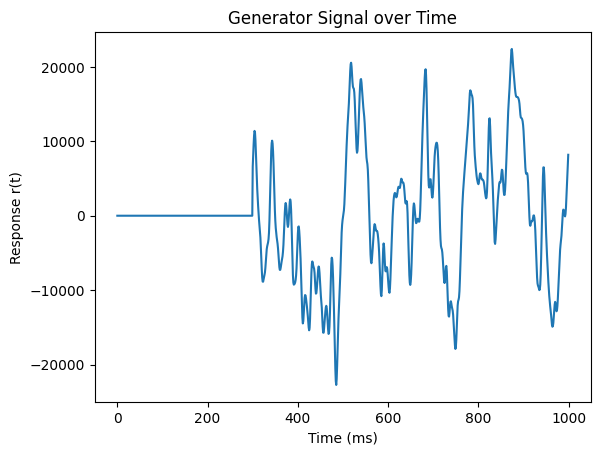

In [23]:
plt.plot(np.arange(0, 1000), response(stim, sta)[:1000])
plt.xlabel('Time (ms)')
plt.ylabel('Response r(t)')
plt.title('Generator Signal over Time')
plt.show()

Estimating `Non-linear function`

In [24]:
def nonlinear_function(r, spikes, num_bins=30):
    
    r_all = r
    r_spikes = r[spikes == 1]

    r_min = np.min(r_all)
    r_max = np.max(r_all)

    bins = np.linspace(r_min, r_max, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    p_r, _ = np.histogram(r_all, bins=bins, density=True)
    p_r_given_spike, _ = np.histogram(r_spikes, bins=bins, density=True)

    eps = 1e-10
    p_r = p_r + eps
    
    f = p_r_given_spike / p_r

    return bin_centers, f

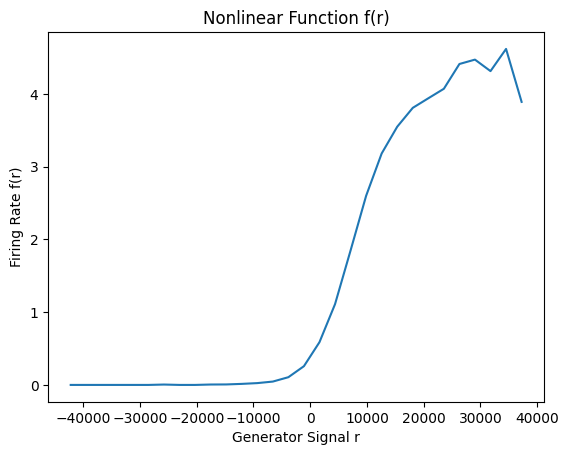

In [25]:
res = response(stim, sta)
bin_centers, f = nonlinear_function(res, rho)
plt.plot(bin_centers, f)
plt.xlabel('Generator Signal r')
plt.ylabel('Firing Rate f(r)')
plt.title('Nonlinear Function f(r)')
plt.show()